<a href="https://colab.research.google.com/github/NIKITOOOK/Brain-tumor/blob/main/yolo11n_%22brain_tumor%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Опухоль головного мозга
## Обучайте ИИ обнаруживать опухоли головного мозга с помощью данных МРТ/КТ для ранней диагностики и улучшения
О наборе данных
Набор данных для обнаружения опухолей мозга состоит из медицинских изображений, полученных с помощью МРТ или КТ, содержащих информацию о наличии, местоположении и характеристиках опухолей мозга. Этот набор данных необходим для обучения алгоритмов компьютерного зрения для автоматизации идентификации опухолей мозга, помогая в ранней диагностике и планировании лечения.

Структура набора данных
Набор данных по опухолям головного мозга делится на два подмножества:

Обучающий набор : состоит из 893 изображений, каждое из которых сопровождается соответствующими аннотациями.
Тестовый набор : включает 223 изображения с парными аннотациями для каждого из них.
Приложения
Применение обнаружения опухолей мозга с помощью компьютерного зрения позволяет проводить раннюю диагностику, планирование лечения и мониторинг прогрессирования опухоли. Анализируя данные медицинской визуализации, такие как МРТ или КТ, системы компьютерного зрения помогают точно идентифицировать опухоли мозга, способствуя своевременному медицинскому вмешательству и персонализированным стратегиям лечения.

https://www.kaggle.com/datasets/ultralytics/brain-tumor/data

🔹 Архитектура модели YOLO11 для детекции опухолей мозга

1. Входные данные

MRI/CT изображения: 2D-снимки мозга с размеченными опухолями.
Размер входного изображения: 640x640 (стандартный размер для YOLO).
Формат аннотаций: YOLO (txt-файлы с bounding boxes).

2. Архитектура YOLO11 — это глубокая сверточная нейросеть (CNN), состоящая из:
* Backbone (ResNet-101 или CSP-Darknet) – глубокая сверточная сеть для извлечения признаков.
* Neck (FPN + PAN) – объединение признаков разных уровней.
* Head (YOLO Head) – определение bounding boxes и классов (negative / positive).

3. Гиперпараметры обучения

Оптимизатор: AdamW
Функция потерь: BCE + CIoU
Размер батча: 16
Кол-во эпох: 100
Аугментации: вращение, изменение яркости/контраста

4. Выходные данные

Bounding boxes (координаты опухоли на снимке).
Класс опухоли (0 – нет опухоли, 1 – есть опухоль).
Метрики: mAP@0.5, Precision, Recall.

## выбор Tesla Т4





In [ ]:
#
# import time
# from google.colab import runtime

# def check_gpu():
#     """Функция проверяет, какой GPU выделен"""
#     gpu_info = !nvidia-smi --query-gpu=name --format=csv,noheader
#     if gpu_info:
#         return gpu_info[0].strip()
#     return None

# while True:
#     gpu_name = check_gpu()
#     print(f"Выделенный GPU: {gpu_name}")

#     if gpu_name and "T4" in gpu_name:
#         print("✅ Получен Tesla T4!")
#         break
#     else:
#         print("❌ Tesla T4 не найден, перезапуск среды")
#         time.sleep(2)  # Даем немного времени перед перезапуском
#         runtime.reset()  # Перезапуск Colab
#

##Загрузить с Kaggle

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("ultralytics/brain-tumor")

# print("Path to dataset files:", path)

100%|██████████| 4.19M/4.19M [00:00<00:00, 161MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.2/112.6 GB disk)


## Загрузка с архиваё

In [ ]:
import zipfile
import os

# путь
zip_path = "/mnt/data/archive.zip"
extract_path = "/mnt/data/brain_tumor_dataset"

# Разархивируем данные
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# проверка структуры файлов
os.listdir(extract_path)


['brain-tumor.yaml', 'brain-tumor']

In [ ]:
# проверка содержимое папки с датасетом
dataset_contents = os.listdir(os.path.join(extract_path, "brain-tumor"))
dataset_contents

['valid', 'train']

In [ ]:
# проверк содержимое папки train
train_path = os.path.join(extract_path, "brain-tumor", "train")
os.listdir(train_path)

['images', 'labels']

In [ ]:
# подсчет количество изображений и аннотаций в train
num_train_images = len(os.listdir(os.path.join(train_path, "images")))
num_train_labels = len(os.listdir(os.path.join(train_path, "labels")))

num_train_images, num_train_labels

(893, 878)

## Training

In [ ]:
# Install the ultralytics package from PyPI
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:

from ultralytics import YOLO

#  модель YOLO11 (легкая версия)
model = YOLO("yolo11n.pt")

# Запуск
results = model.train(data=os.path.join(extract_path, "brain-tumor.yaml"),
                      epochs=10,
                      imgsz=640,
                      batch=16,
                      device="cuda")  #GPU, если доступен

# результаты обучения
results


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 88.1MB/s]


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/mnt/data/brain_tumor_dataset/brain-tumor.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

100%|██████████| 4.23M/4.23M [00:00<00:00, 69.9MB/s]
Unzipping /content/datasets/brain-tumor.zip to /content/datasets/brain-tumor...: 100%|██████████| 2225/2225 [00:00<00:00, 3877.41file/s]

Dataset download success ✅ (1.5s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 20.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/brain-tumor/train/labels... 878 images, 15 backgrounds, 0 corrupt: 100%|██████████| 893/893 [00:00<00:00, 2205.91it/s]

train: New cache created: /content/datasets/brain-tumor/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/brain-tumor/valid/labels... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<00:00, 1656.63it/s]

val: New cache created: /content/datasets/brain-tumor/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.39G      1.297      3.797      1.187         12        640: 100%|██████████| 56/56 [00:18<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        223        241    0.00269      0.748      0.131     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.21G      1.235      2.795      1.099         13        640: 100%|██████████| 56/56 [00:15<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        223        241      0.414      0.357      0.319      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.19G      1.179      2.358      1.104         13        640: 100%|██████████| 56/56 [00:14<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        223        241       0.42      0.692      0.415      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.21G      1.139      2.024      1.097         14        640: 100%|██████████| 56/56 [00:14<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        223        241      0.463      0.761      0.485      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.21G       1.11      1.792      1.089         13        640: 100%|██████████| 56/56 [00:14<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        223        241      0.455        0.8      0.495      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.21G      1.064      1.607      1.069         17        640: 100%|██████████| 56/56 [00:14<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        223        241      0.471      0.771      0.491      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.21G      1.015      1.486      1.032         15        640: 100%|██████████| 56/56 [00:14<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        223        241      0.445      0.826      0.473      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       2.2G     0.9685      1.396      1.019         13        640: 100%|██████████| 56/56 [00:14<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        223        241      0.483      0.852      0.475      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       2.2G     0.9389      1.325     0.9974         13        640: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        223        241      0.473      0.828      0.495       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       2.2G     0.8991      1.274     0.9872         12        640: 100%|██████████| 56/56 [00:14<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        223        241       0.46      0.817      0.472      0.346



10 epochs completed in 0.051 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


                   all        223        241      0.473      0.825      0.495      0.361
              negative        142        154      0.596      0.805      0.622      0.454
              positive         81         87      0.349      0.845      0.368      0.268
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7fe73bae90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

* mAP@0.5 (Mean Average Precision): 49.5% → Средняя точность по всем классам.
* mAP@0.5-0.95: 36.1% → Более строгий показатель точности.
* Precision (Точность): 47.3% → Доля предсказанных опухолей, которые действительно являются опухолями.
* Recall (Полнота): 82.5% → Насколько хорошо модель находит все опухоли.
* Speed (время предсказания): 3.3ms на изображение.

## прошлый вариант предсказания

```
from ultralytics import YOLO
# Load a model
model = YOLO("path/to/best.pt")  # load a brain-tumor fine-tuned model
# Inference using the model
results = model.predict("https://ultralytics.com/assets/brain-tumor-sample.jpg")

```



In [ ]:
# from ultralytics import YOLO
# from tqdm import tqdm
# import time

# # Загружаем модель YOLOv11
# model = YOLO("yolo11n.pt")

# # Количество эпох
# epochs = 10

# # Создаём progress bar
# progress_bar = tqdm(total=epochs, desc="Обучение YOLO", unit="epoch")

# # Запускаем обучение
# results = model.train(data="/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor.yaml",
#                       epochs=epochs,
#                       verbose=True)  # Выводит стандартный прогресс

# # Обновляем tqdm по количеству эпох
# for epoch in range(epochs):
#     time.sleep(1)  # Симуляция ожидания
#     progress_bar.update(1)

# progress_bar.close()  # Закрываем progress bar


In [ ]:
# from ultralytics import YOLO

# # Load a model
# model = YOLO("/content/runs/detect/train/weights/best.pt")  # load a fine-tuned model

# # Inference using the model (img/video/stream)
# results = model.predict("/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor/train/images/00124_8.jpg", save=True)

In [ ]:
# model = YOLO("/content/runs/detect/train/weights/last.pt")  # load a fine-tuned model
# results = model.predict("https://ultralytics.com/assets/brain-tumor-sample.jpg", save=True)

## Визуал

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/datasets/brain-tumor/valid/images/val_1 (172).jpg: 640x640 1 positive, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


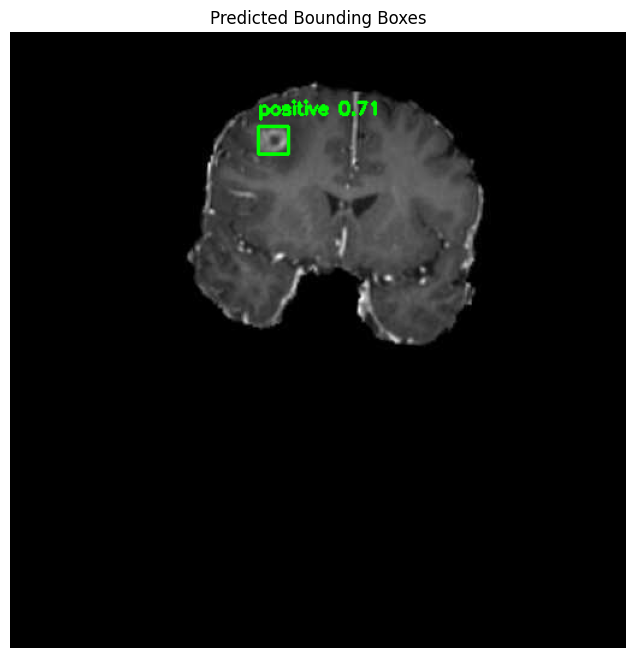

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.metrics import ConfusionMatrix
from pathlib import Path

# Загрузка обученной модели
model = YOLO("runs/detect/train/weights/best.pt")

# Выбираем тестовое изображение
TEST_IMAGE_PATH = "/content/datasets/brain-tumor/valid/images/val_1 (172).jpg"  # Укажите свое изображение

def visualize_prediction(image_path, model):
    """ Визуализация предсказаний YOLO """
    img = cv2.imread(image_path)
    results = model.predict(image_path, save=True, show=True)

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            label = f"{model.names[cls]} {conf:.2f}"

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Predicted Bounding Boxes")
    plt.axis("off")
    plt.show()
    # Визуализация предсказаний
visualize_prediction(TEST_IMAGE_PATH, model)


image 1/1 /content/datasets/brain-tumor/valid/images/val_1 (172).jpg: 640x640 1 positive, 14.0ms
Speed: 3.4ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


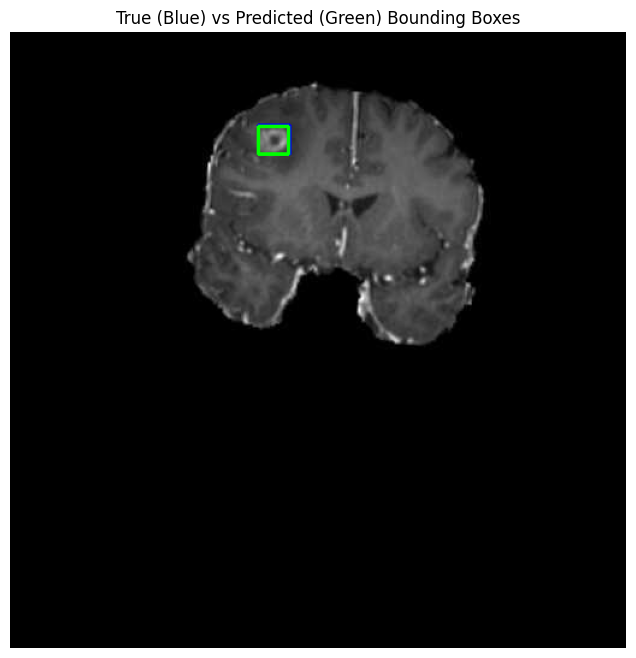

In [ ]:
# ===== 2. Сравнение предсказанных и реальных боксов ===== #
def compare_pred_true(image_path, model, label_path):
    """ Сравнение предсказанных и реальных bounding boxes """
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    # Загружаем разметку (YOLO формат: class x_center y_center width height)
    with open(label_path, "r") as f:
        labels = f.readlines()

    for label in labels:
        cls, x_center, y_center, w, h = map(float, label.split())
        x1 = int((x_center - w / 2) * width)
        y1 = int((y_center - h / 2) * height)
        x2 = int((x_center + w / 2) * width)
        y2 = int((y_center + h / 2) * height)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # GT боксы синим

    # Отобразим предсказания (зеленым)
    results = model.predict(image_path)
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Предсказанные - зеленые

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("True (Blue) vs Predicted (Green) Bounding Boxes")
    plt.axis("off")
    plt.show()

# Укажите путь к файлу с аннотациями
LABEL_PATH = "/content/datasets/brain-tumor/valid/labels/val_1 (172).txt"  # Укажите путь к разметке
compare_pred_true(TEST_IMAGE_PATH, model, LABEL_PATH)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/datasets/brain-tumor/valid/labels.cache... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


                   all        223        241      0.473      0.827      0.495      0.363
              negative        142        154      0.596      0.805      0.622      0.458
              positive         81         87       0.35      0.849      0.367      0.268
Speed: 2.0ms preprocess, 5.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


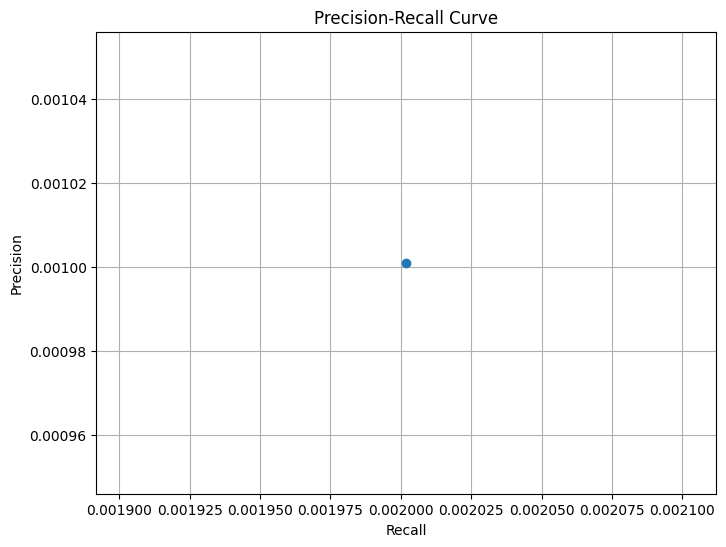

In [ ]:
# ===== 3. Построение Precision-Recall Curve ===== #
def plot_precision_recall(model):
    """ Генерация Precision-Recall кривой """
    metrics = model.val()
    pr_curve = metrics.curves_results[0][0]  # Получаем Precision-Recall
    confidence = pr_curve[0]
    precision = pr_curve[1]
    recall = pr_curve[2]

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', linestyle='-')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid()
    plt.show()

plot_precision_recall(model)


In [ ]:
# Предположим, у вас есть массивы

# y_true = [...]  # Истинные метки (0 или 1)
# y_scores = [...]  # Предсказанные вероятности (от 0 до 1)

# precision, recall, _ = precision_recall_curve(y_true, y_scores)

# plt.plot(recall, precision, marker='o')
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.grid()
# plt.show()

In [ ]:
# from ultralytics import YOLO

# # Загружаем обученную модель
# model = YOLO("runs/detect/train/weights/best.pt")

# # Выполняем предсказания на тестовых изображениях
# test_images = ["valid/images/test1.jpg", "valid/images/test2.jpg"]  # Укажите список тестовых изображений
# results = model(test_images)

# y_scores = []
# for r in results:
#     if len(r.boxes) > 0:
#         conf = r.boxes.conf  # Уверенность предсказания
#         y_scores.append(float(conf.max()))  # Берем максимальную уверенность
#     else:
#         y_scores.append(0.0)  # Если предсказания нет, вероятность = 0



0: 640x640 1 negative, 1 positive, 3.3ms
1: 640x640 1 negative, 1 positive, 3.3ms
2: 640x640 1 negative, 3.3ms
3: 640x640 1 negative, 3.3ms
4: 640x640 1 negative, 3.3ms
5: 640x640 1 positive, 3.3ms
6: 640x640 1 positive, 3.3ms
7: 640x640 1 positive, 3.3ms
8: 640x640 1 negative, 1 positive, 3.3ms
9: 640x640 (no detections), 3.3ms
10: 640x640 1 positive, 3.3ms
11: 640x640 1 positive, 3.3ms
12: 640x640 1 negative, 1 positive, 3.3ms
13: 640x640 1 negative, 3.3ms
14: 640x640 1 negative, 1 positive, 3.3ms
15: 640x640 1 positive, 3.3ms
16: 640x640 1 negative, 1 positive, 3.3ms
17: 640x640 1 negative, 1 positive, 3.3ms
18: 640x640 1 negative, 1 positive, 3.3ms
19: 640x640 1 negative, 1 positive, 3.3ms
20: 640x640 1 negative, 1 positive, 3.3ms
21: 640x640 1 negative, 3.3ms
22: 640x640 1 negative, 1 positive, 3.3ms
23: 640x640 1 negative, 1 positive, 3.3ms
24: 640x640 1 positive, 3.3ms
25: 640x640 (no detections), 3.3ms
26: 640x640 1 positive, 3.3ms
27: 640x640 2 negatives, 2 positives, 3.3ms
2

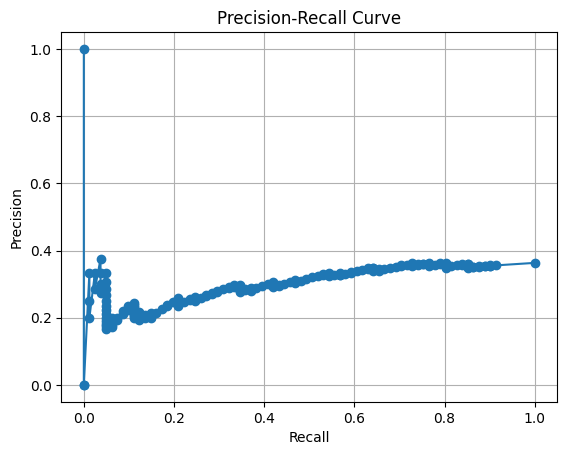

In [ ]:
from ultralytics import YOLO
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Загружаем обученную модель
model = YOLO("runs/detect/train/weights/best.pt")

# Находим все тестовые изображения
test_images = glob.glob("/content/datasets/brain-tumor/valid/images/*.jpg")  # Или PNG, если используется PNG

# Выполняем предсказания
results = model(test_images)

# Инициализируем списки
y_true = []
y_scores = []

# Обрабатываем каждое изображение
for img_path, result in zip(test_images, results):
    # Загружаем реальную разметку из файла аннотации
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt").replace(".png", ".txt")
    try:
        with open(label_path, "r") as f:
            lines = f.readlines()
            class_ids = [int(line.split()[0]) for line in lines]  # Берем class_id
            y_true.append(1 if 1 in class_ids else 0)  # Если есть 1 (positive), метка = 1, иначе 0
    except FileNotFoundError:
        y_true.append(0)  # Если файла разметки нет, считаем, что метка = 0 (negative)

    # Берем максимальную уверенность предсказания
    if len(result.boxes) > 0:
        conf = result.boxes.conf  # Уверенность предсказания
        y_scores.append(float(conf.max()))  # Берем максимум
    else:
        y_scores.append(0.0)  # Если предсказаний нет, вероятность = 0

# Преобразуем в массивы numpy
y_true = np.array(y_true, dtype=int)
y_scores = np.array(y_scores, dtype=float)

# Строим Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision, marker='o', linestyle='-')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


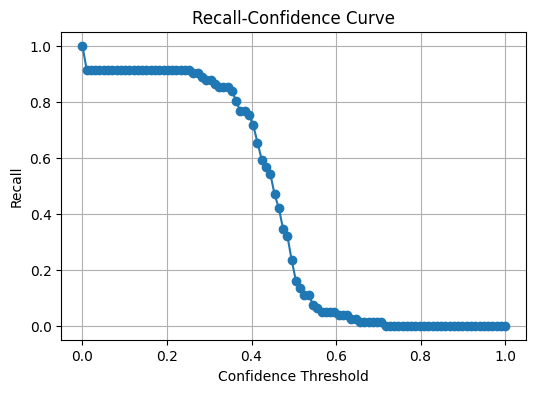

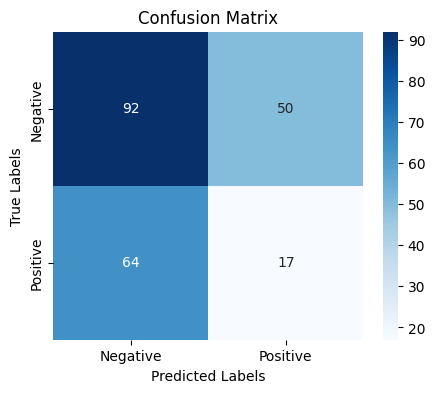

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Преобразуем вероятности в предсказанные метки с порогом 0.5
y_pred = (y_scores >= 0.5).astype(int)

# Данные уверенности предсказаний и истинные метки
conf_thresholds = np.linspace(0, 1, 100)  # Порог уверенности от 0 до 1
recalls = []

for threshold in conf_thresholds:
    y_pred_thresholded = (y_scores >= threshold).astype(int)
    recall = sum((y_pred_thresholded == 1) & (y_true == 1)) / sum(y_true == 1)
    recalls.append(recall)

# Строим Recall-Confidence Curve
plt.figure(figsize=(6, 4))
plt.plot(conf_thresholds, recalls, marker='o', linestyle='-')
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall-Confidence Curve")
plt.grid()
plt.show()

# Строим Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
